# Data preprocessing

In [312]:
# Importing libraries

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Model selection and evaluation
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

# Data preprocessing
from sklearn.pipeline import Pipeline

# Machine learning models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [313]:
# Reading the dataset
df = pd.read_csv('/content/students_performance.csv')

In [314]:
# Calculating the overall score and dropping the course grades
df['overall_score'] = df[['math_score', 'reading_score', 'writing_score']].mean(axis=1)
df = df.drop(columns=['math_score', 'reading_score', 'writing_score'])

In [315]:
# changing the column name for race/ethnicity
df = df.rename(columns={'race/ethnicity': 'race_ethnicity'})

# Data analysis

In [316]:
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,overall_score
0,female,group B,bachelor's degree,standard,none,72.666667
1,female,group C,some college,standard,completed,82.333333
2,female,group B,master's degree,standard,none,92.666667
3,male,group A,associate's degree,free/reduced,none,49.333333
4,male,group C,some college,standard,none,76.333333


In [317]:
df.shape

(1000, 6)

In [318]:
# Checking for null values
df.isnull().sum()

gender                         0
race_ethnicity                 0
parental_level_of_education    0
lunch                          0
test_preparation_course        0
overall_score                  0
dtype: int64

In [319]:
# Summary statistics for numeric columns
df.describe()

,overall_score
count,1000.000000
mean,67.770667
std,14.257326
min,9.000000
25%,58.333333
50%,68.333333
75%,77.666667
max,100.000000


In [320]:
# Summary statistics for categorical columns
df.describe(include=['object'])

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course
count,1000,1000,1000,1000,1000
unique,2,5,6,2,2
top,female,group C,some college,standard,none
freq,518,319,226,645,642


In [321]:
# Unique values in categorical columns
for column in df.select_dtypes(include=['object']).columns:
    print('\n' + column)
    print(df[column].unique())


gender
['female' 'male']

race_ethnicity
['group B' 'group C' 'group A' 'group D' 'group E']

parental_level_of_education
["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']

lunch
['standard' 'free/reduced']

test_preparation_course
['none' 'completed']


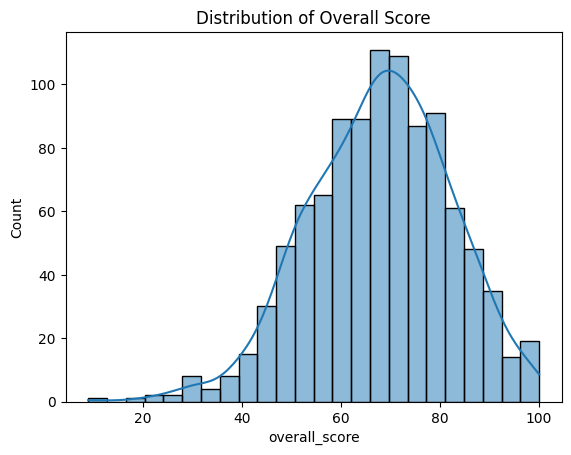

In [322]:
# Visualization of the distribution of the target variable
sns.histplot(df['overall_score'], kde=True)
plt.title('Distribution of Overall Score')
plt.show()

In [323]:
# Identifying outliers in overall_score and removing them
q1 = df['overall_score'].quantile(0.25)
q3 = df['overall_score'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df = df[(df['overall_score'] >= lower_bound) & (df['overall_score'] <= upper_bound)]

# Model Training

In [324]:
# Defining categorical features
categorical_features = ['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch', 'test_preparation_course']
print(categorical_features)

['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch', 'test_preparation_course']


In [325]:
# Encoding
df = pd.get_dummies(df, columns=categorical_features, dtype=int)

In [327]:
# Splitting the data into features and target
X = df.drop('overall_score', axis=1)
y = df['overall_score']

In [328]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [329]:
# Function to evaluate the model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
    print('R-squared:', r2_score(y_test, y_pred))
    return model

In [330]:
# Neural Network
nn_model = MLPRegressor(random_state=42, max_iter=2000, early_stopping=True, n_iter_no_change=10)

param_grid_nn = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

nn_search = RandomizedSearchCV(nn_model, param_grid_nn, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error', random_state=42)
nn_search.fit(X_train, y_train)
nn_best_model = nn_search.best_estimator_
evaluate_model(nn_best_model, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mean Absolute Error: 10.182757747262324
Mean Squared Error: 159.9511247781299
R-squared: 0.17469237177257113


MLPRegressor(alpha=0.001, early_stopping=True, max_iter=2000, random_state=42)

In [331]:
# XGBoost
xgb_model = XGBRegressor(random_state=42)

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0]
}

xgb_search = RandomizedSearchCV(xgb_model, param_grid_xgb, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error', random_state=42)
xgb_search.fit(X_train, y_train)
xgb_best_model = xgb_search.best_estimator_
evaluate_model(xgb_best_model, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mean Absolute Error: 9.961199947338008
Mean Squared Error: 153.24161292354634
R-squared: 0.20931176768461102


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [332]:
# Gradient Boosting
gbm_model = GradientBoostingRegressor(random_state=42)

param_grid_gbm = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0]
}

gbm_search = RandomizedSearchCV(gbm_model, param_grid_gbm, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error', random_state=42)
gbm_search.fit(X_train, y_train)
gbm_best_model = gbm_search.best_estimator_
evaluate_model(gbm_best_model, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mean Absolute Error: 9.95198318318721
Mean Squared Error: 153.55572570422794
R-squared: 0.20769102463338296


GradientBoostingRegressor(learning_rate=0.01, n_estimators=200, random_state=42,
                          subsample=0.7)

In [333]:
# Support Vector Regressor
svr_model = SVR()

param_grid_svr = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

svr_search = RandomizedSearchCV(svr_model, param_grid_svr, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error', random_state=42)
svr_search.fit(X_train, y_train)
svr_best_model = svr_search.best_estimator_
evaluate_model(svr_best_model, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mean Absolute Error: 9.849557993984924
Mean Squared Error: 148.93416287265444
R-squared: 0.2315371280260331


SVR(C=10, gamma='auto', kernel='linear')

In [334]:
# Elastic Net
en_model = ElasticNet(random_state=42)

param_grid_en = {
    'alpha': [0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.5, 0.9]
}

en_search = GridSearchCV(en_model, param_grid_en, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')
en_search.fit(X_train, y_train)
en_best_model = en_search.best_estimator_
evaluate_model(en_best_model, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Mean Absolute Error: 9.864355287382052
Mean Squared Error: 149.0131034407164
R-squared: 0.23112981452268322


ElasticNet(alpha=0.1, random_state=42)

In [335]:
# K-Nearest Neighbors Regressor
knn_model = KNeighborsRegressor()

param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_search = RandomizedSearchCV(knn_model, param_grid_knn, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error', random_state=42)
knn_search.fit(X_train, y_train)
knn_best_model = knn_search.best_estimator_
evaluate_model(knn_best_model, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mean Absolute Error: 10.675041876046897
Mean Squared Error: 182.14668581000237
R-squared: 0.060168851804823675


KNeighborsRegressor(metric='manhattan', n_neighbors=7)

In [336]:
# Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_search = RandomizedSearchCV(rf_model, param_grid_rf, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error', random_state=42)
rf_search.fit(X_train, y_train)
rf_best_model = rf_search.best_estimator_
evaluate_model(rf_best_model, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mean Absolute Error: 9.827087815824509
Mean Squared Error: 151.28747813139748
R-squared: 0.21939461238346603


RandomForestRegressor(max_depth=4, min_samples_leaf=4, min_samples_split=10,
                      random_state=42)

In [337]:
# AdaBoost Regressor
ada_model = AdaBoostRegressor(random_state=42)

param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0]
}

ada_search = RandomizedSearchCV(ada_model, param_grid_ada, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error', random_state=42)
ada_search.fit(X_train, y_train)
ada_best_model = ada_search.best_estimator_
evaluate_model(ada_best_model, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mean Absolute Error: 9.873029846679819
Mean Squared Error: 151.14353169216554
R-squared: 0.22013733985424244


AdaBoostRegressor(learning_rate=0.1, n_estimators=100, random_state=42)

In [338]:
import joblib

# Saving the model to a file
joblib_file = 'final_model.pkl'
joblib.dump(rf_best_model, joblib_file)
print(f'Model saved to {joblib_file}')

Model saved to final_model.pkl
